In [63]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import seaborn as sns
import os
from multiprocessing import Pool
from pathlib import Path
import sys

# set path to the utils
notebook_dir = os.getcwd()
notebook_name = "check_generated_data.ipynb"

PATH = Path(notebook_dir) / Path(notebook_name) 

sys.path.insert(0, str(Path(*[i for i in PATH.parts[:PATH.parts.index("VIEWS_FAO_index")+1]]) / "src/utils"))   

from set_paths import setup_project_paths, get_logo_path
setup_project_paths(PATH)

from utils_plotting import plot_time_series, plot_random_monthly_and_yearly_data
from utils_annual_aggregation import aggregate_monthly_to_yearly
from utils_feature_eng_per_100k import feature_eng_fat_per_100k
#from utils_cumulative_distribution import calculate_global_cumulative_distribution
from utils_global_probabilities import calculate_global_probabilities
from utils_country_probabilities import calculate_all_country_probabilities
from utils_return_periods import calculate_return_periods
from utils_check_expected_features import check_expected_features    
from utils_date_index import calculate_date_from_index 

In [2]:
print(np.__version__) # 1.26.4 used
print(pd.__version__) # 2.2.1 used
print(matplotlib.__version__) # 3.8.4 used
print(sns.__version__) # 0.13.2 used

1.26.4
2.2.1
3.8.4
0.13.2


In [3]:
# load save minimal dataframes and check the expected feature agian
df_monthly = pd.read_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/processed/pilot_return_periods_monthly.pkl")
df_yearly = pd.read_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/processed/pilot_return_periods_yearly.pkl")

In [4]:
country_list = df_yearly['c_id'].unique().tolist()

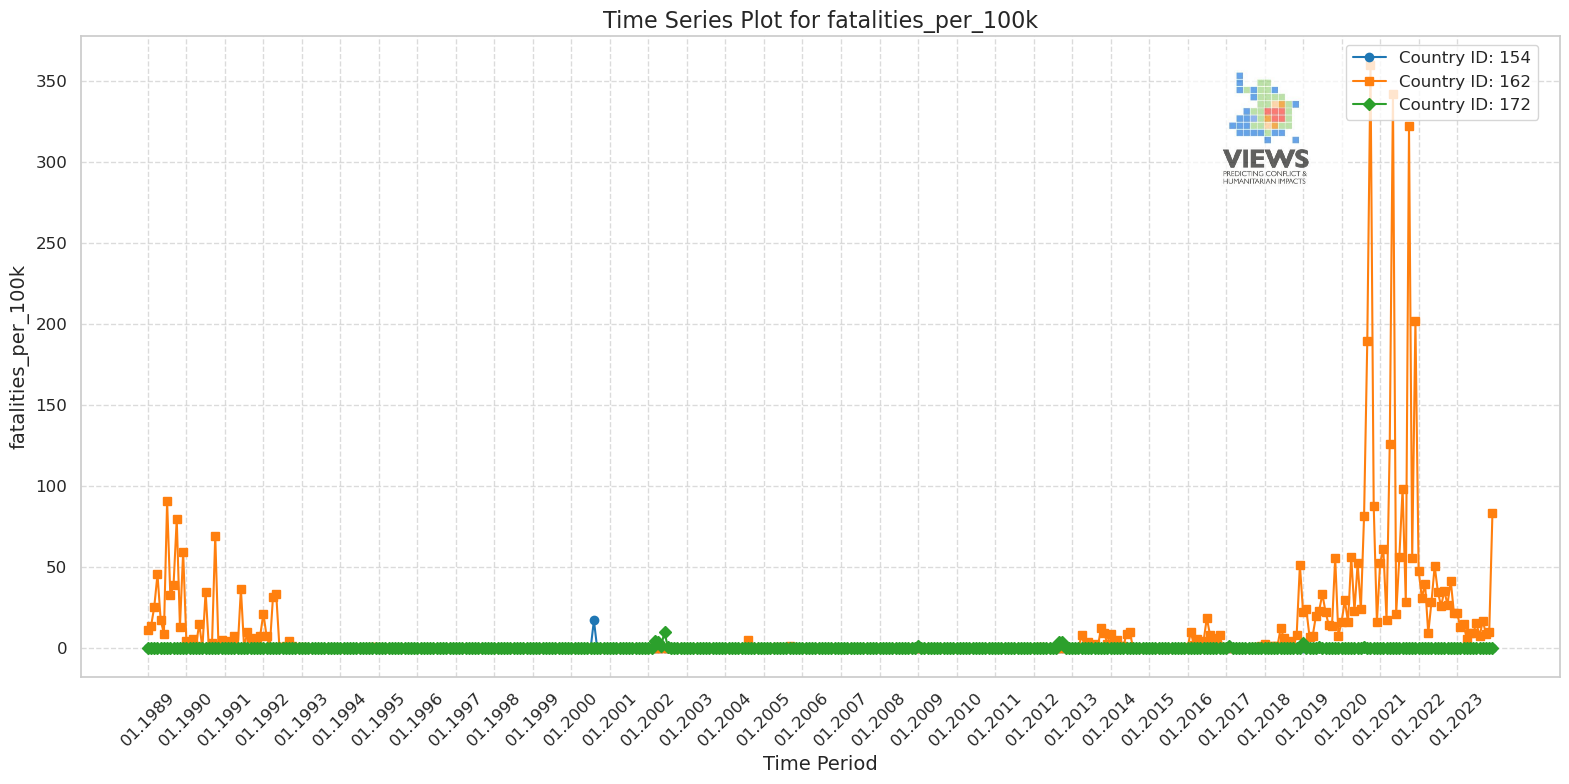

In [5]:
plot_time_series(df_monthly, country_ids=country_list[5:8], feature='fatalities_per_100k', figsize=(16, 8))

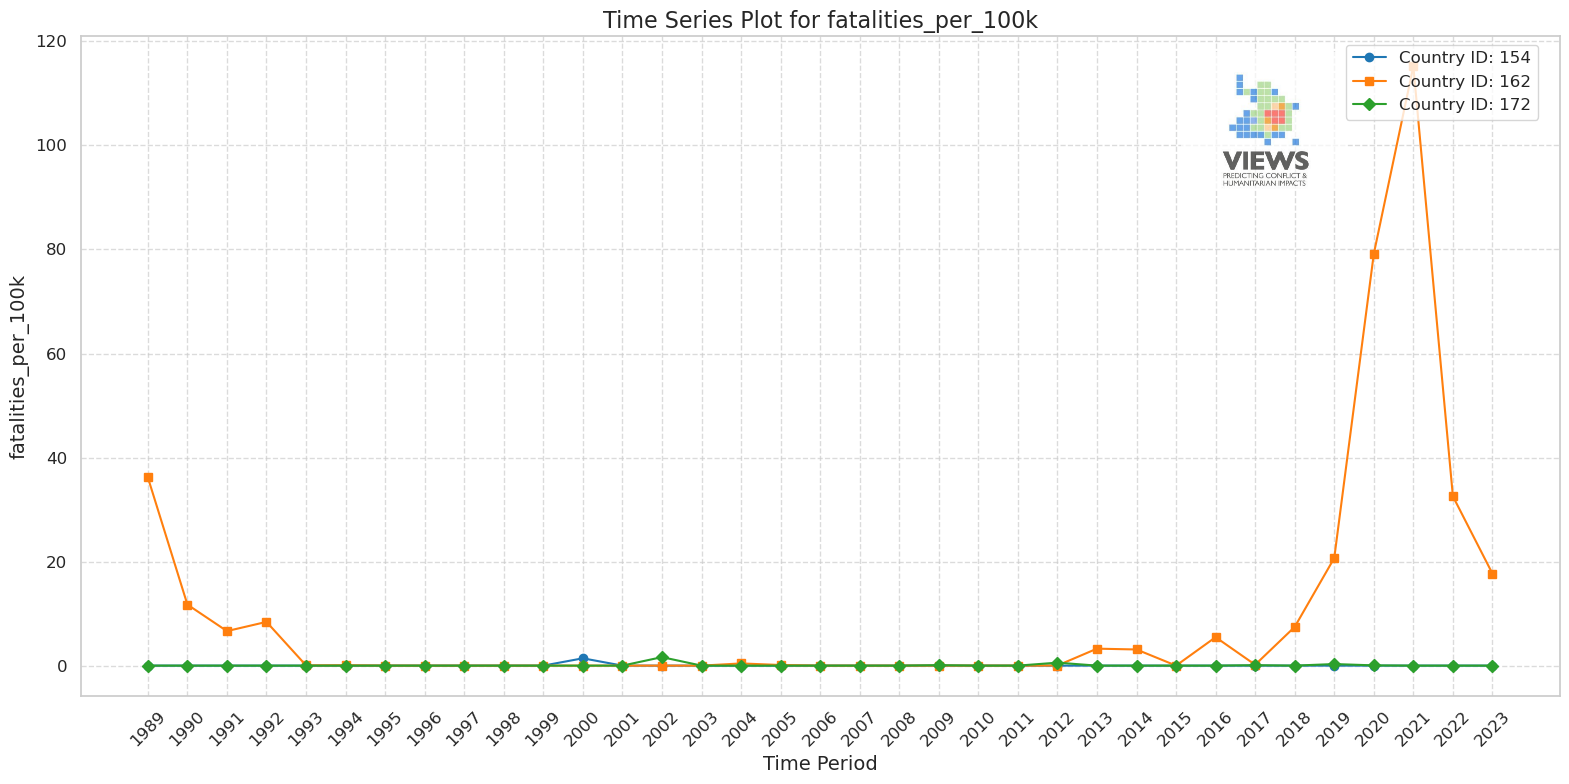

In [67]:
plot_time_series(df_yearly, country_ids=country_list[5:8], feature='fatalities_per_100k', figsize=(16, 8))

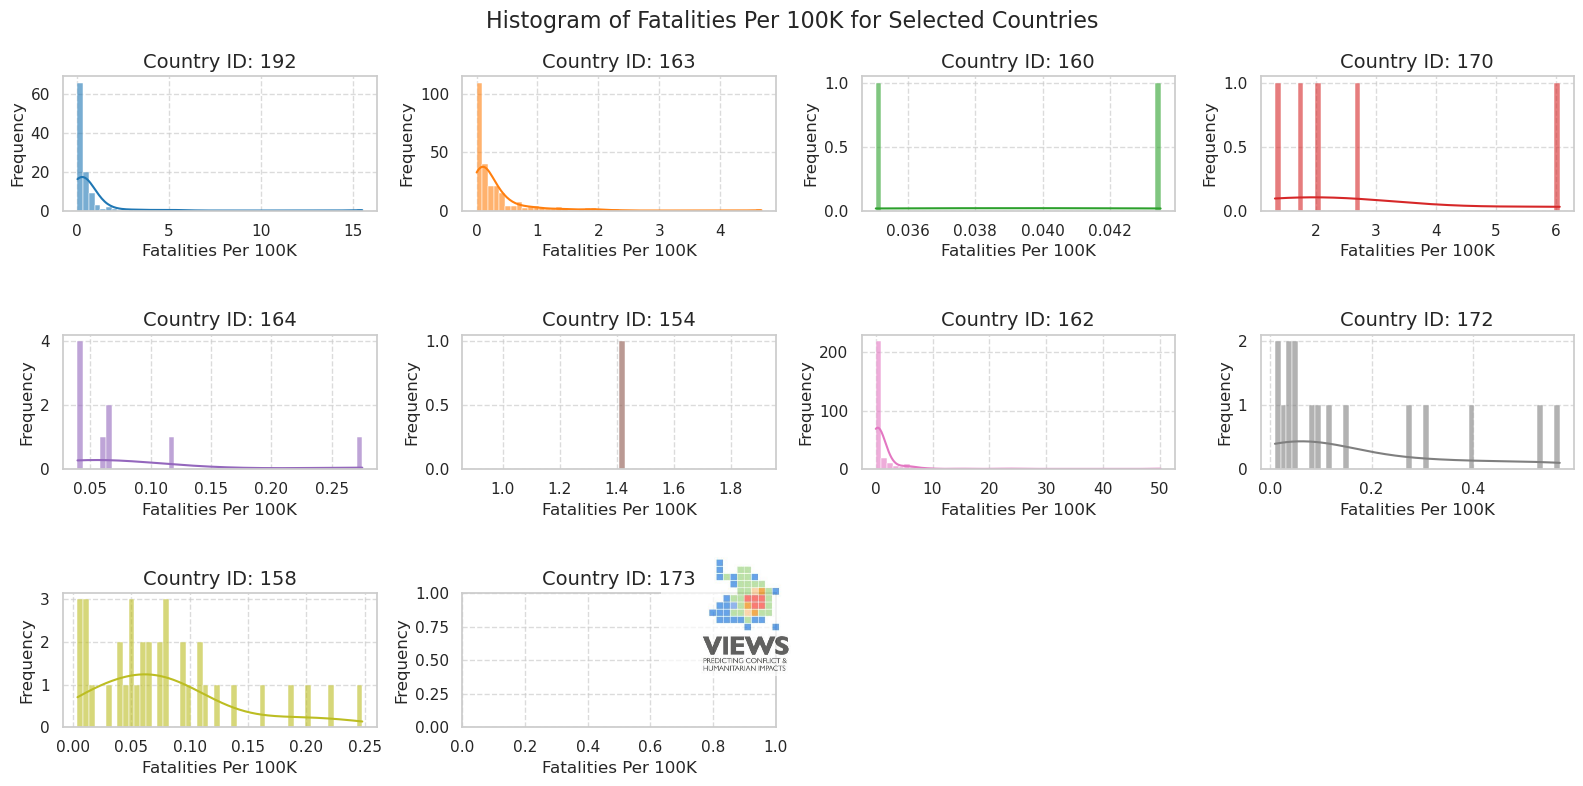

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_feature_histogram(df, country_ids, feature, figsize=(16, 8)):
    """
    Plots histograms of a specified feature for multiple countries in subplots.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    country_ids (list): List of country IDs to filter the data.
    feature (str): The feature/column to plot.
    logo_path (str): Path to the logo image file.
    figsize (tuple, optional): Figure size for the plot. Defaults to (16, 8).

    Returns:
    None
    """
    
    # Ensure country_ids is a list
    if not isinstance(country_ids, list):
        raise ValueError('Country IDs should be provided as a list.')

    # Determine the number of rows and columns for subplots
    num_countries = len(country_ids)
    num_cols = min(4, num_countries)
    num_rows = (num_countries + num_cols - 1) // num_cols

    # Set the figure size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    # Set the style
    sns.set(style="whitegrid")

    # Define a color palette
    palette = sns.color_palette("tab10", num_countries)

    # Plot each country's histogram in a subplot
    for idx, country_id in enumerate(country_ids):
        # Filter the data for the specified country and feature
        sub_df = df[df['c_id'] == country_id][feature]

        # Remove zero values
        sub_df = sub_df[sub_df != 0]

        # Create the histogram plot
        sns.histplot(sub_df, bins=50, kde=True, color=palette[idx], ax=axes[idx], alpha=0.6)

        # Add titles and labels
        axes[idx].set_title(f'Country ID: {country_id}', fontsize=14)
        axes[idx].set_xlabel(feature.replace("_", " ").title(), fontsize=12)
        axes[idx].set_ylabel('Frequency', fontsize=12)

        # Customize the grid
        axes[idx].grid(True, linestyle='--', alpha=0.7)

    # Remove any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    # super title
    fig.suptitle(f'Histogram of {feature.replace("_", " ").title()} for Selected Countries', fontsize=16)

    # now insert our logo under the legende - first check the path if 
    PATH_logo = get_logo_path(PATH) / "VIEWS_logo.png"

    #only plot if logo is available other wise just show the plot but print a warning
    if not Path(PATH_logo).is_file():

        print("Logo not found, please make sure the logo is available in the logos folder")

    else:

        # Load the image
        image = plt.imread(PATH_logo)

        # Create OffsetImage and AnnotationBbox
        imagebox = OffsetImage(image, zoom=0.3, alpha=0.7)
        ab = AnnotationBbox(imagebox, (0.9, 0.9), frameon=False, xycoords='axes fraction', zorder=3)

    # Add AnnotationBbox to the plot
    plt.gca().add_artist(ab)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
plot_feature_histogram(df_yearly, country_list[:10], 'fatalities_per_100k')

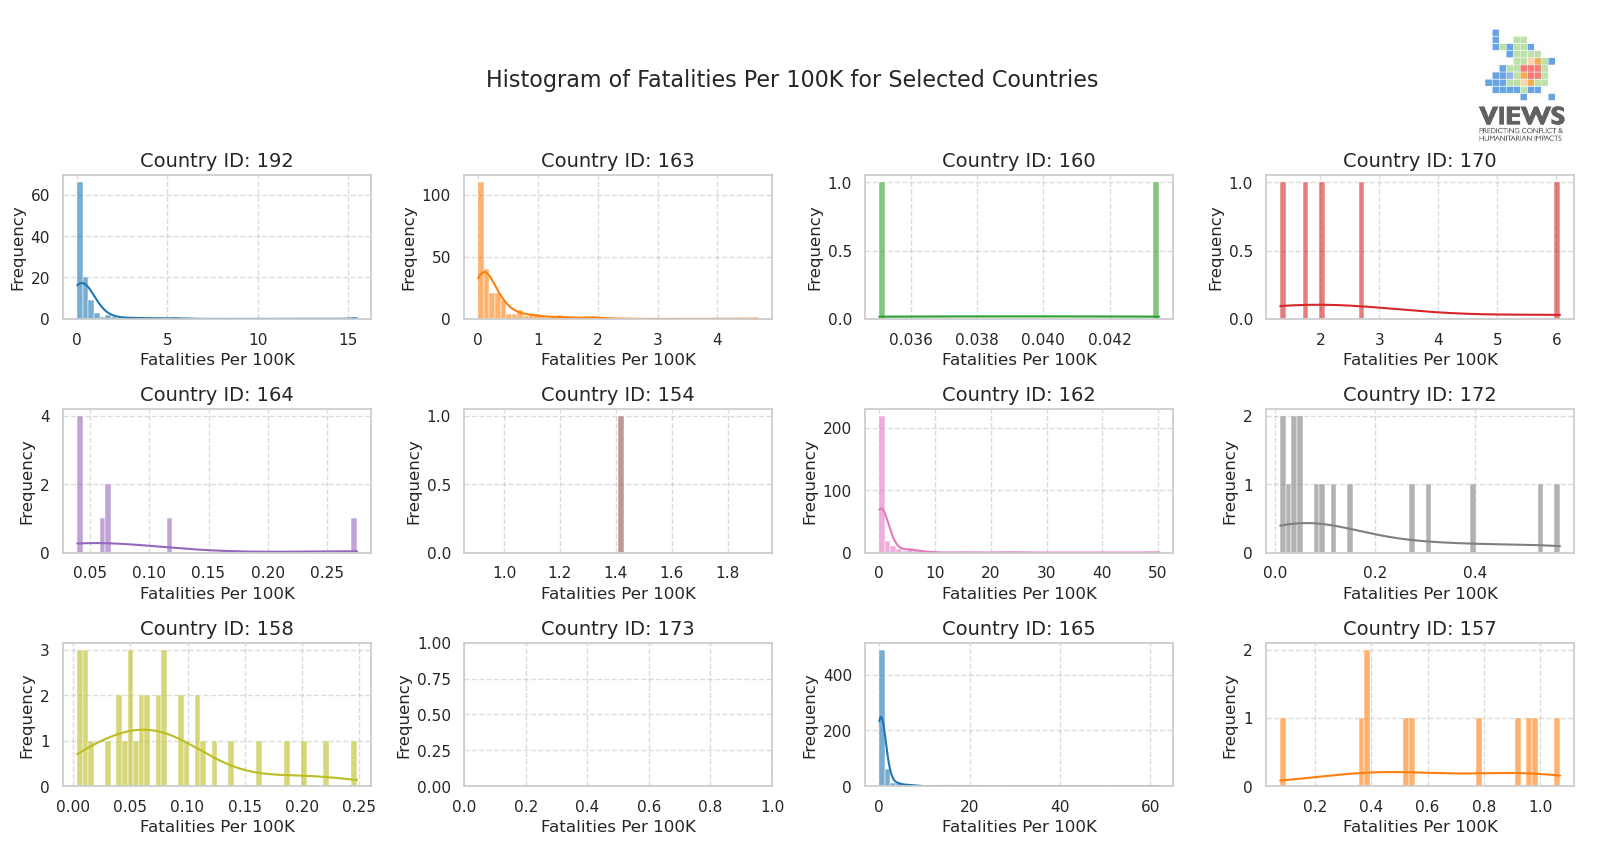

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_feature_histogram(df, country_ids, feature, figsize=(16, 8)):
    """
    Plots histograms of a specified feature for multiple countries in subplots.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    country_ids (list): List of country IDs to filter the data.
    feature (str): The feature/column to plot.
    logo_path (str): Path to the logo image file.
    figsize (tuple, optional): Figure size for the plot. Defaults to (16, 8).

    Returns:
    None
    """
    
    # Ensure country_ids is a list
    if not isinstance(country_ids, list):
        raise ValueError('Country IDs should be provided as a list.')

    # Determine the number of rows and columns for subplots
    num_countries = len(country_ids)
    num_cols = min(4, num_countries)
    num_rows = (num_countries + num_cols - 1) // num_cols

    # Set the figure size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    # Set the style
    sns.set(style="whitegrid")

    # Define a color palette
    palette = sns.color_palette("tab10", num_countries)

    # Plot each country's histogram in a subplot
    for idx, country_id in enumerate(country_ids):
        # Filter the data for the specified country and feature
        sub_df = df[df['c_id'] == country_id][feature]

        # Remove zero values
        sub_df = sub_df[sub_df != 0]

        # Create the histogram plot
        sns.histplot(sub_df, bins=50, kde=True, color=palette[idx], ax=axes[idx], alpha=0.6)

        # Add titles and labels
        axes[idx].set_title(f'Country ID: {country_id}', fontsize=14)
        axes[idx].set_xlabel(feature.replace("_", " ").title(), fontsize=12)
        axes[idx].set_ylabel('Frequency', fontsize=12)

        # Customize the grid
        axes[idx].grid(True, linestyle='--', alpha=0.7)

    # Remove any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add a super title
    fig.suptitle(f'Histogram of {feature.replace("_", " ").title()} for Selected Countries', fontsize=16)

    # Add a logo next to the super title if available
    PATH_logo = get_logo_path(PATH) / 'VIEWS_logo.png'
    if not PATH_logo.is_file():
        print("Logo not found, please make sure the logo is available in the logos folder")
    else:
        # Load the image
        image = plt.imread(PATH_logo)

        # Create OffsetImage and AnnotationBbox
        imagebox = OffsetImage(image, zoom=0.3, alpha=0.7)
        ab = AnnotationBbox(imagebox, (0.95, 0.96), frameon=False, xycoords='figure fraction', zorder=3)
        fig.add_artist(ab)

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make space for the super title
    plt.show()

# Example usage:
plot_feature_histogram(df_yearly, country_list[:12], 'fatalities_per_100k')

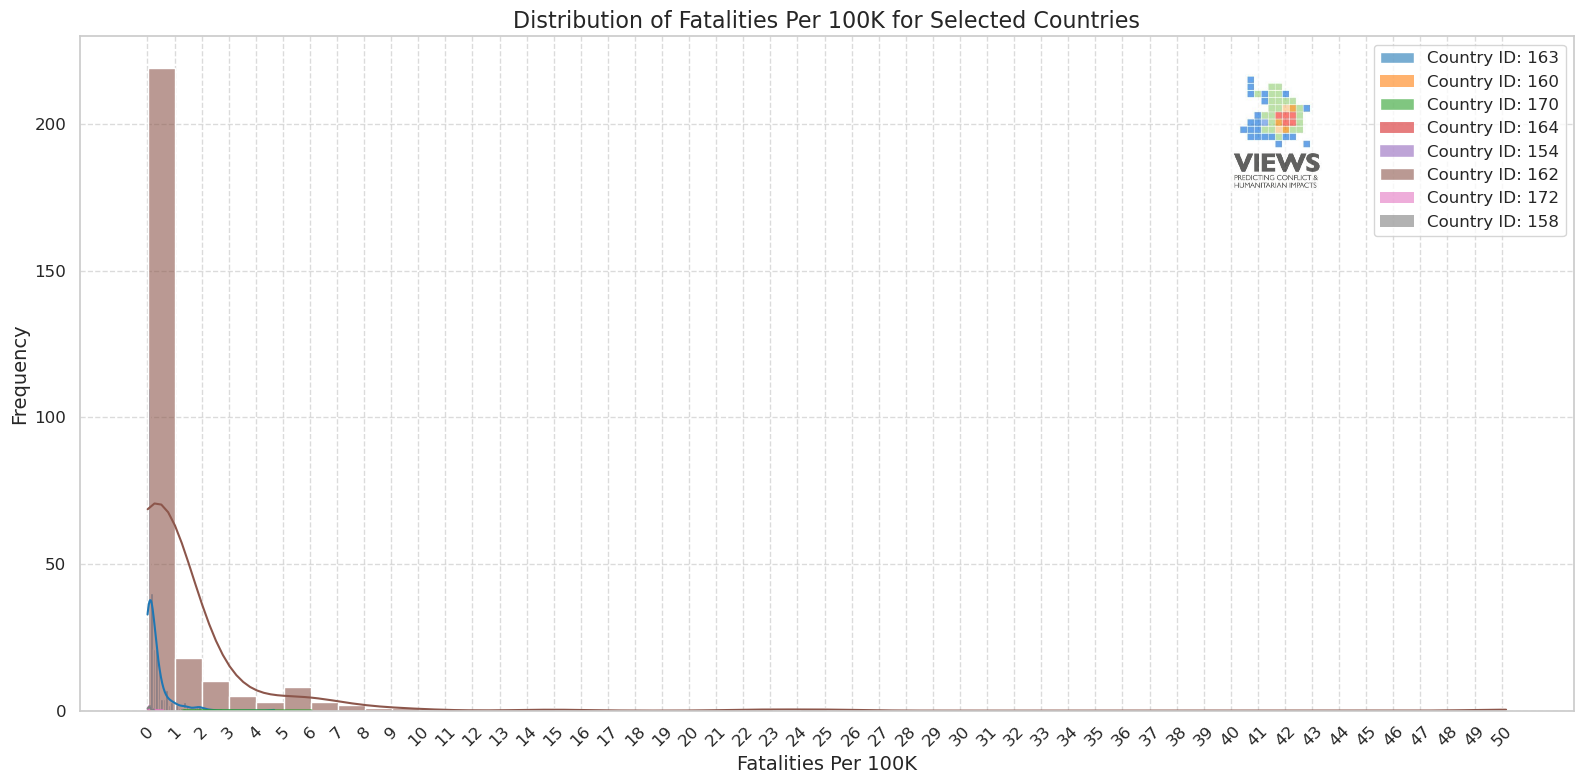

In [72]:
def plot_feature_histogram(df, country_ids, feature, figsize=(16, 8)):
    """
    Plots a histogram of a specified feature for multiple countries.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    country_ids (list): List of country IDs to filter the data.
    feature (str): The feature/column to plot.
    logo_path (str): Path to the logo image file.
    figsize (tuple, optional): Figure size for the plot. Defaults to (12, 8).

    Returns:
    None
    """
    
    # Ensure country_ids is a list
    if not isinstance(country_ids, list):
        raise ValueError('Country IDs should be provided as a list.')

    # Set the figure size
    plt.figure(figsize=figsize)

    # Set the style
    sns.set(style="whitegrid")

    # Define a color palette
    palette = sns.color_palette("tab10", len(country_ids))

    # Plot each country's histogram
    for idx, country_id in enumerate(country_ids):
        # Filter the data for the specified country and feature
        sub_df = df[df['c_id'] == country_id][feature]

        # Remove zero values
        sub_df = sub_df[sub_df != 0]

        # Create the histogram plot
        sns.histplot(sub_df, bins=50, kde=True, color=palette[idx], label=f'Country ID: {country_id}', alpha=0.6)

    # Add titles and labels
    plt.title(f'Distribution of {feature.replace("_", " ").title()} for Selected Countries', fontsize=16)
    plt.xlabel(feature.replace("_", " ").title(), fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Customize the grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Customize the x-ticks
    min_val = df[df['c_id'].isin(country_ids)][feature].min()
    max_val = df[df['c_id'].isin(country_ids)][feature].max()
    range_vals = np.arange(round(min_val), round(max_val) + 1, 1)
    x_ticks = range_vals
    plt.xticks(x_ticks, fontsize=12, rotation=45)

    # Customize the y-ticks
    plt.yticks(fontsize=12)

    # Add a legend
    plt.legend(loc='upper right', fontsize=12)

    # now insert our logo under the legende - first check the path if 
    PATH_logo = get_logo_path(PATH) / "VIEWS_logo.png"

    #only plot if logo is available other wise just show the plot but print a warning
    if not Path(PATH_logo).is_file():

        print("Logo not found, please make sure the logo is available in the logos folder")

    else:

        # Load the image
        image = plt.imread(PATH_logo)

        # Create OffsetImage and AnnotationBbox
        imagebox = OffsetImage(image, zoom=0.3, alpha=0.7)
        ab = AnnotationBbox(imagebox, (0.8, 0.87), frameon=False, xycoords='axes fraction', zorder=3)

    # Add AnnotationBbox to the plot
    plt.gca().add_artist(ab)
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
plot_feature_histogram(df_yearly, country_list[1:10], 'fatalities_per_100k')

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

def large_to_small_bar(df, country_ids, feature, figsize=(16, 8)):
    # Filter out zero values
    df = df[df[feature] != 0]
    
    # Find the largest value for each country
    largest_values = df[df['c_id'].isin(country_ids)].groupby('c_id')[feature].max()
    
    # Sort the countries by their largest value in descending order
    sorted_values = largest_values.sort_values(ascending=True)
    
    # Create the bar plot
    plt.figure(figsize=figsize)
    sorted_values.plot(kind='barh')
    plt.xlabel('Largest Value')
    plt.ylabel('Country ID')
    plt.title('Largest Values Observed Across Countries')
    plt.gca().invert_yaxis()  # Invert y-axis to have the largest values at the top
    plt.show()


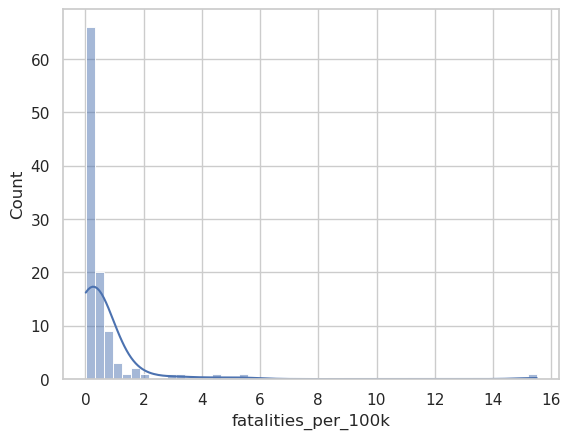

40     0.186826
41     0.053379
47     0.262706
71     0.012744
154    0.358159
Name: fatalities_per_100k, dtype: float64

In [55]:
sub_df = df_yearly[df_yearly['c_id'] == 192]['fatalities_per_100k']

# remove zero values
sub_df = sub_df[sub_df != 0]

sns.histplot(sub_df, bins=50, kde=True)

# Assuming sub_df is a DataFrame or Series
min_val = sub_df.min()
max_val = sub_df.max()

# Generate the range of values
range_vals = np.arange(round(min_val), round(max_val) + 1, 1)

# Combine the values into a single list
x_ticks = [min_val] + list(range_vals) + [max_val]

plt.show()

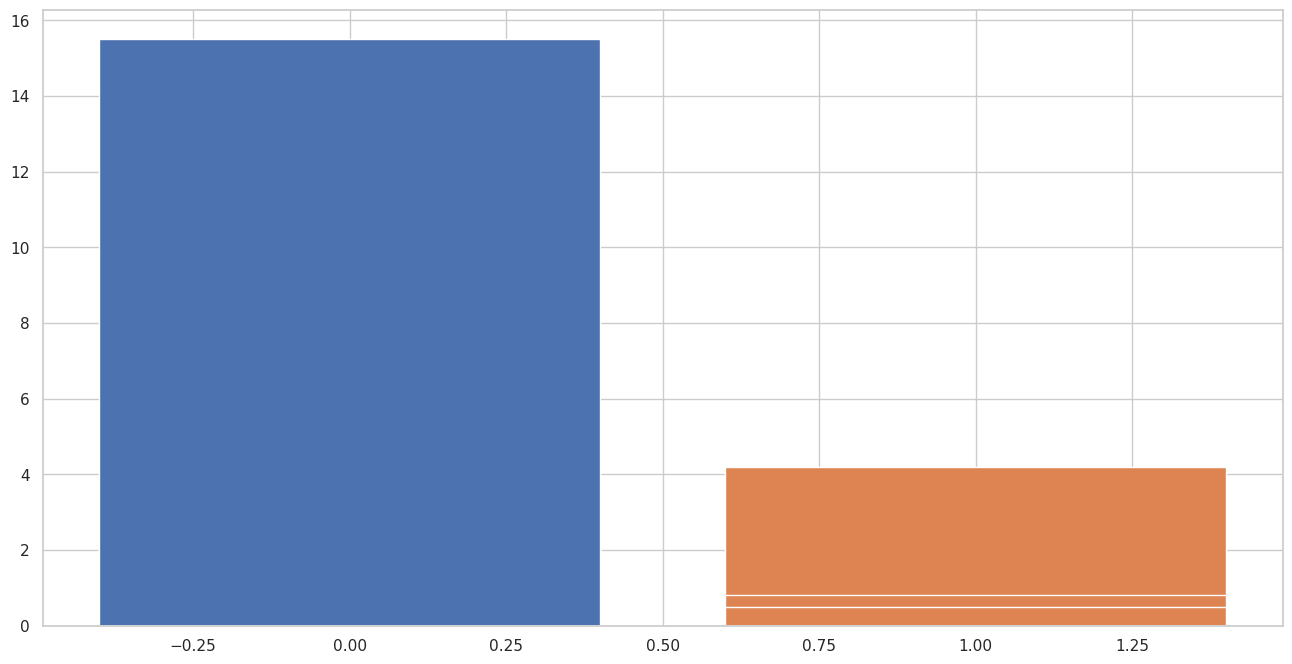

In [37]:
def name_to_come(df,country_ids, feature, fig_size = (16, 8)):

    df_subset = df[df['c_id'].isin(country_ids)]

    # Create the bar plot with the highest value first (left) and the lowest value last (right)
    plt.figure(figsize=fig_size)

    for i, c_id in enumerate(country_ids):
        plt.bar(i, df_subset[df_subset['c_id'] == c_id][feature], label=c_id)

    plt.show()

name_to_come(df_yearly, country_ids=[192, 191], feature='fatalities_per_100k', fig_size=(16, 8))

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

def large_to_small_bar(df, country_ids, feature, figsize=(16, 8)):
    df = df[df[feature] != 0]
    
    # Find the largest value for each country
    largest_values = df[df['c_id'].isin(country_ids)].groupby('c_id')[feature].max()
    
    # Sort the countries by their largest value in descending order
    sorted_values = largest_values.sort_values(ascending=False)
    
    # Create the bar plot using matplotlib
    plt.figure(figsize=figsize)
    plt.bar(sorted_values.index.astype(str), sorted_values.values)
    plt.ylabel('Largest Value')
    plt.xlabel('Country ID')
    plt.title('Largest Values Observed Across Countries')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.show()


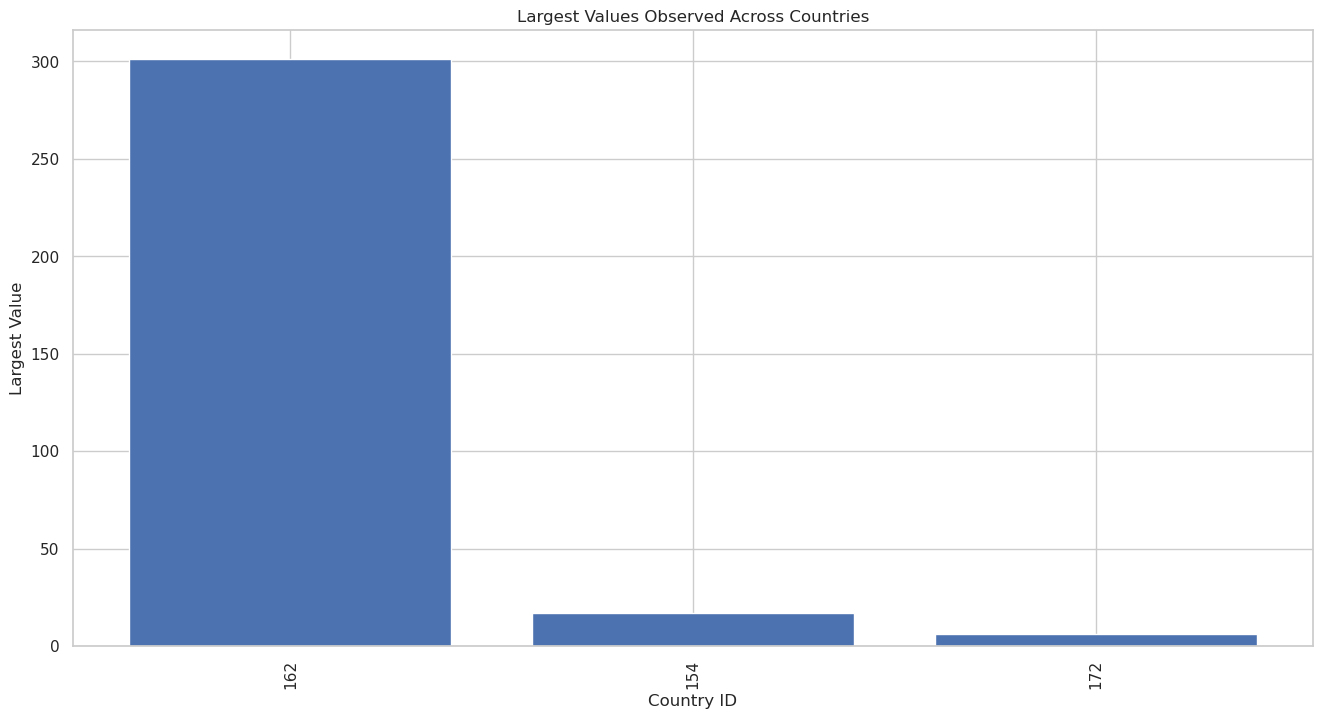

In [36]:
large_to_small_bar(df_monthly, country_ids=country_list[5:8], feature='fatalities_per_100k', figsize=(16, 8))

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_largest_values(df, country_ids):
    # Filter the DataFrame to include only the specified country IDs
    filtered_df = df[df['c_id'].isin(country_ids)]
    
    # Find the largest value observed for each country
    largest_values = filtered_df.groupby('country_id')['value'].max()
    
    # Sort these values in descending order
    sorted_values = largest_values.sort_values(ascending=False)
    
    # Create a bar plot with the sorted values
    plt.figure(figsize=(10, 6))
    sorted_values.plot(kind='bar')
    plt.xlabel('Country ID')
    plt.ylabel('Largest Value')
    plt.title('Largest Values Observed Across Countries')
    plt.show()

# Example usage
# Assuming df is your DataFrame and it has columns 'country_id' and 'value'
# country_ids = [1, 2, 3, 4, 5]
# plot_largest_values(df, country_ids)

In [10]:
plot_largest_values(df_monthly, country_ids=[192, 191])

KeyError: 'country_id'